# LIM implementation

In [1]:
import nc_time_axis
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy as ctp
from importlib import reload

from forenso.model import lim
from forenso.utils import preproc, eof, enso, metric
import forenso.geoplot as gpl

plt.style.use("../../paper.mplstyle")

## Load data

In [2]:
param = dict(
    datapath= [
    {'path': "../../data/cmip6/CESM2/piControl/ts_Amon_CESM2_piControl_r1i1p1f1.nc", 'vname': 'ts'},
    {'path': "../../data/cmip6/CESM2/piControl/zos_Amon_CESM2_piControl_r1i1p1f1.nc", 'vname': 'zos'}
    ],
    lon_range=[130, -70],
    lat_range=[-31, 32],
    grid_step=1,
    batch_size=8,
    hidden_layer=64,
    n_eof=20, 
)

# Preprocess
land_area_mask = preproc.process_data(
    "../../data/cmip6/CESM2/piControl/sftlf_fx_CESM2_piControl_r1i1p1f1.nc", ['sftlf'],
    antimeridian=True, lon_range=param['lon_range'], lat_range=param['lat_range'],
    grid_step=1,
)['sftlf']

da_arr = []
for f in param['datapath']:
    print(f"Load {f['vname']}")
    da = preproc.process_data(
        f['path'], [f['vname']], antimeridian=True, lon_range=param['lon_range'], 
        lat_range=param['lat_range'], climatology='month', detrend_from=None,
        grid_step=1 
    )[f"{f['vname']}a"]
    da = da.where(land_area_mask == 0.0)
    # Normalize
    normalizer = preproc.Normalizer(method='zscore')
    da_norm = normalizer.fit_transform(da)
    da_norm.attrs = {'normalizer': normalizer}
    da_arr.append(da_norm)

ds = xr.merge(da_arr)

Sort longitudes and latitudes in ascending order, respectively
Preprocess sftlf:
Roll longitudes.
Set the dateline to the new longitude zero.
Get selected area: lon=[-50 110], lat=[-31, 32]!
Interpolate grid on res 1
Load ts
Sort longitudes and latitudes in ascending order, respectively
Preprocess ts:
Roll longitudes.
Set the dateline to the new longitude zero.
Get selected area: lon=[-50 110], lat=[-31, 32]!
Interpolate grid on res 1
Compute anomalies:
Load zos
Sort longitudes and latitudes in ascending order, respectively
Preprocess zos:
Roll longitudes.
Set the dateline to the new longitude zero.
Get selected area: lon=[-50 110], lat=[-31, 32]!
Interpolate grid on res 1
Compute anomalies:


In [3]:
# PCA
reload(eof)
pca_lst = []
for i, var in enumerate(ds.data_vars):
    print(f"Create EOF of {var}!")
    n_components = param['n_eof'] // (i+1)
    pca_lst.append(
        eof.SpatioTemporalPCA(ds[var], n_components=n_components),
    )
pca_coll = eof.PCACollection(pca_lst)
n_components = pca_coll.n_components

Create EOF of tsa!
Create EOF of zosa!


In [4]:
# Split in training and test data
data = pca_coll.get_principal_components()
idx_train = int(0.8*len(data['time']))
data_train = data[:,:idx_train]
data_test = data[:,idx_train:]

## Create LIM

In [5]:
reload(lim)        
tau = 2
model = lim.LIM(tau)
model.fit(data_train.data)

# model.save(f"../../output/lim/ts_CESM2_piControl/lim_n_{n_components}_tau_{tau}.pt")

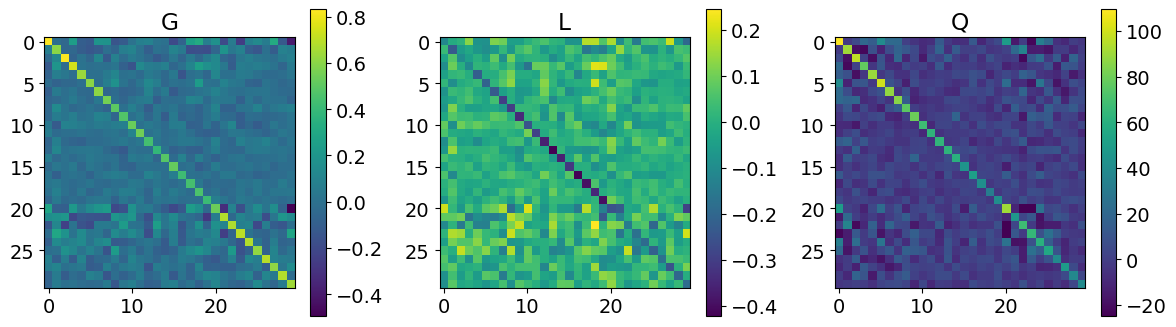

In [6]:
# Plot G
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))
pos = axs[0].imshow(model.G)
axs[0].set_title('G')
fig.colorbar(pos, ax=axs[0])
pos = axs[1].imshow(np.real(model.L))
axs[1].set_title('L')
fig.colorbar(pos, ax=axs[1])
pos = axs[2].imshow(np.real(model.Q))
axs[2].set_title('Q')
fig.colorbar(pos, ax=axs[2])

In [7]:
# Forecast
lag=5
time_range=np.arange(1, 200)
x = data_test[:, time_range]
x_hind = model.forecast_mean(x, lag=lag)

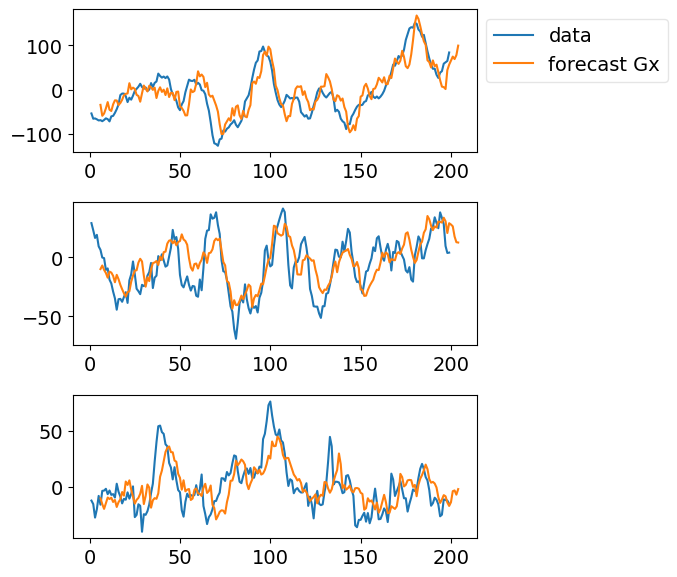

In [8]:
# Plot time evolution
idx_components = [0,1,2]
fig, axs = plt.subplots(len(idx_components), figsize=(7, len(idx_components)*2))
for i, c in enumerate(idx_components):
    axs[i].plot(time_range, x[c, :], label='data') 
    axs[i].plot(time_range+lag, x_hind[c, :], label='forecast Gx') 

_ = axs[0].legend(bbox_to_anchor=(1,1), loc="upper left")

### Different lag times

Slippage effect

In [1]:
time_range = np.arange(0, 100)

fig, axs = plt.subplots(2, figsize=(7, 8), sharex=True)
x = data_test.isel(time=time_range)
axs[0].plot(time_range, x[0], linewidth=5, color='k', label='data') 
axs[1].plot(time_range, x[0], linewidth=5, color='k', label='data') 

lag_arr = [1,3, 6, 9]
for lag in lag_arr:
    x_hind = model.forecast_mean(x, lag=lag)
    axs[0].plot(time_range+lag, x_hind[0], label=rf'LIM $\tau=${lag}') 
    x_hind_useL = model.forecast_use_L_mean(x, lag=lag)
    axs[1].plot(time_range+lag, x_hind_useL[0], label=rf'LIM $\tau=${lag}') 

for ax in axs:
    ax.legend()
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"EOF$_1$")


In [ ]:
# Rollout
import pandas as pd
max_lag = 15
lag_arr = np.arange(0, max_lag+1, 1)
lim_frcst = xr.DataArray(
    data=model.rollout_mean(data_test, lag_arr), 
    coords={'lag': lag_arr, 'eof': data_test['eof'],
            'time': data_test['time'].data}
)

t_init = 50
buff = [lim_frcst.isel(time=t_init+lag, lag=lag) for lag in range(max_lag)]
rollout = xr.concat(buff, dim=pd.Index(lim_frcst['time'][t_init:t_init+max_lag].data, name='time'))

fig, ax = plt.subplots()
data_test.isel(time=slice(t_init, t_init+max_lag), eof=0).plot(ax=ax)
rollout.isel(eof=0).plot(ax=ax)


## Evaluation in data space

### Variance for each month

In [ ]:
# Normalization parameters
lag = 6

norm_attrs = dict()
for var in list(ds.data_vars):
    norm_attrs[var] = ds[var].attrs

# Forecast
z = data_test.data
z_frcst = np.real(model.forecast_mean(z, lag=lag))
# Transform to data space
x_map = pca_coll.reconstruction(z.T[lag:, :], times=data_test['time'][lag:])
x_frcst_map = pca_coll.reconstruction(z_frcst.T[:-lag, :], times=data_test['time'][lag:])

# Unnormalize
x_map = xr.merge(
    [ds[var].attrs['normalizer'].inverse_transform(x_map[var]) for var in ds.data_vars])
x_frcst_map = xr.merge(
    [ds[var].attrs['normalizer'].inverse_transform(x_frcst_map[var]) for var in ds.data_vars])

In [ ]:
reload(enso)
nino_indices = enso.get_nino_indices(x_map['tsa'], antimeridian=True)
nino_indices_frcst = enso.get_nino_indices(x_frcst_map['tsa'], antimeridian=True)

std_n34 = nino_indices['nino34'].groupby('time.month').std(skipna=True)
std_n34_frcst = nino_indices_frcst['nino34'].groupby('time.month').std(skipna=True)

fig, ax = plt.subplots()
ax.plot(std_n34['month'], std_n34.data, 'o-', label='CESM2')
ax.plot(std_n34_frcst['month'], std_n34_frcst.data, 'o-', label=rf'LIM ($\tau$={lag})')
ax.set_xticks(std_n34['month'].data)
ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax.set_ylabel("STD(Nino3.4)")
ax.legend()

### Random forecast example

In [ ]:
import cftime
timepoint = x_map['time'][78]
print(timepoint.data)


plparam = {'tsa': dict(vmin=-2, vmax=2, eps=0.25),
           'zosa': dict(vmin=-0.1, vmax=.1, eps=0.025)}

fig = plt.figure(figsize=(len(param['datapath']) * 5, 4))
proj=ctp.crs.PlateCarree(central_longitude=180)

for j, var in enumerate(list(x_map.data_vars)):
    ax = fig.add_subplot(2, len(param['datapath']), 2*j+1, projection=proj)
    gpl.plot_map(x_map[var].sel(time=timepoint), 
                 ax=ax, central_longitude=180,
                 bar='discrete', **plparam[var],
                 kwargs_cb=dict(label=rf"data {var}"))
    ax = fig.add_subplot(2, len(param['datapath']), 2*j+2, projection=proj)
    gpl.plot_map(x_frcst_map[var].sel(time=timepoint), 
                 ax=ax, central_longitude=180,
                 bar='discrete', **plparam[var],
                 kwargs_cb=dict(label=rf"frcst {var}"))
plt.tight_layout()

### Compute metrics

In [ ]:
reload(metric)
lag_arr = np.arange(1,25,1) 

# Normalization parameters
eval_dict = []
nino_indices = []
for lag in lag_arr:
    print(f"Forecast of lag={lag}")
    # Forecast
    z = data_test.data
    z_frcst = np.real(model.forecast_mean(z, lag=lag))
    # Transform to data space
    x_map = pca_coll.reconstruction(z.T[lag:, :], times=data_test['time'][lag:])
    x_frcst_map = pca_coll.reconstruction(z_frcst.T[:-lag, :], 
                                          times=data_test['time'][lag:])
    # Unnormalize
    x_map = xr.merge(
        [ds[var].attrs['normalizer'].inverse_transform(x_map[var]) for var in ds.data_vars])
    x_frcst_map = xr.merge(
        [ds[var].attrs['normalizer'].inverse_transform(x_frcst_map[var]) for var in ds.data_vars])

    buff_metric = metric.frcst_metrics(x_map, x_frcst_map)
    eval_dict.append(buff_metric)

    # Nino indices
    nino_indices.append({
        'data': enso.get_nino_indices(x_map['tsa'], antimeridian=True),
        'frcst': enso.get_nino_indices(x_frcst_map['tsa'], antimeridian=True),
    })

# Transform list of dicts to dict of dataarrays
eval_dict = metric.listofdicts_to_dict(eval_dict)
for key, arr in eval_dict.items():
    eval_dict[key] = xr.concat(arr, dim=pd.Index(lag_arr, name='lag'))
     
nino_indices = metric.listofdicts_to_dict(nino_indices)
for key, arr in nino_indices.items():
    nino_indices[key] = xr.concat(arr, dim=pd.Index(lag_arr, name='lag')) 


In [ ]:
# Save metrics to file
import torch
fname = f"/{'_'.join(ds.data_vars)}_eof_{param['n_eof']}_stlim" 
torch.save(eval_dict, f"../../output/lim/" + fname + "_metrics.pt", pickle_protocol=4)
torch.save(nino_indices, f"../../output/lim" + fname + "_nino_indices.pt", pickle_protocol=4)

### Plot map metrics

In [ ]:
# Plot ACC maps
plparam = dict(metric='acc', vmin=-1, vmax=1, color='RdBu_r')

fig = plt.figure(figsize=(len(param['datapath']) * 4, len(eval_dict)*3))
proj=ctp.crs.PlateCarree(central_longitude=180)
for i, storer in enumerate(eval_dict):
    map = storer[plparam['metric']]
    for j, var in enumerate(list(map.data_vars)):
        idx = len(param['datapath'])*i + j + 1
        ax = fig.add_subplot(len(eval_dict), len(param['datapath']), idx, projection=proj)
        gpl.plot_map(map[var], ax=ax, vmin=plparam['vmin'], vmax=plparam['vmax'], 
                     central_longitude=180, color=plparam['color'],
                     label=rf"{plparam['metric']} {var} ($\tau$={storer['lag']})")
plt.tight_layout()

In [ ]:
# Plot MSE
plparam = {'tsa': dict(vmin=0, vmax=1.0, color='viridis'),
           'zosa': dict(vmin=0, vmax=0.004, color='viridis')}

fig = plt.figure(figsize=(len(param['datapath']) * 4, len(eval_dict)*3))
proj=ctp.crs.PlateCarree(central_longitude=180)
for i, storer in enumerate(eval_dict):
    map = storer['mse']
    for j, var in enumerate(list(map.data_vars)):
        idx = len(param['datapath'])*i + j + 1
        ax = fig.add_subplot(len(eval_dict), len(param['datapath']), idx, projection=proj)
        gpl.plot_map(map[var], ax=ax, vmin=plparam[var]['vmin'], vmax=plparam[var]['vmax'], 
                     central_longitude=180, color=plparam[var]['color'],
                     label=rf"MSE {var} ($\tau$={storer['lag']})")
plt.tight_layout()

### Average metrices over lead time

In [ ]:
# Plot average ACC, Pattern Corr, and MSE
metrics = ['acc', 'pattern_corr', 'mse']

lag_arr = np.zeros(len(eval_dict))
metric_mean = {}
for m in metrics:
    lag_arr = np.zeros(len(eval_dict))
    temp_mean = []
    for i, eval in enumerate(eval_dict):
        temp_mean.append(eval[m].mean())
        lag_arr[i] = eval['lag']
    metric_mean[m] = xr.concat(temp_mean, dim='lag')

fig, axs = plt.subplots(len(metrics), len(param['datapath']), sharex=True,
                        figsize=(4*len(param['datapath']), 2*len(metrics)))
for i, (key, val) in enumerate(metric_mean.items()):
    for j, var in enumerate(val.data_vars):
        ax = axs[i] if len(param['datapath'])==1 else axs[i,j]
        ax.plot(lag_arr, val[var], 'o-')
        ax.set_ylabel(key)
        ax.set_title(var)
        ax.set_xlabel(r"$\tau$")


### Time dependent metrics

In [ ]:
# Identify ENSO events
reload(enso)
f_sst = "../../data/cmip6/CESM2/piControl/ts_Amon_CESM2_piControl_r1i1p1f1.nc"
vname = 'ts'
month_range = [11, 2]

da_sst = xr.open_dataset(f_sst)[vname]
# Check dimensions
da_sst = preproc.check_dimensions(da_sst, sort=True)
# Anomalies
ssta = preproc.compute_anomalies(da_sst, group='month')
# Nino indices
nino_indices = enso.get_nino_indices(ssta)
# ENSO event classification 
nino_indices = enso.get_nino_indices(ssta)
enso_classes = enso.get_enso_flavors_N3N4(
    nino_indices, month_range=month_range, mean=True, threshold='std',
    offset=0.0, min_diff=0.0, drop_volcano_year=False
)

In [ ]:
# MSE over time
mname = 'pattern_corr'
mean_window = 3
time_idx = np.arange(0, 12*20)
time_arr = data_test.isel(time=time_idx)['time']

# Select events
enso_events = enso_classes.loc[(enso_classes['start'] > time_arr.min())
                               & (enso_classes['end'] < time_arr.max())]
nino_events = enso_events.loc[(enso_events['type'] == 'Nino_EP')
                              | (enso_events['type'] == 'Nino_CP')
                              | (enso_events['type'] == 'Nino')]
nina_events = enso_events.loc[(enso_events['type'] == 'Nina_EP')
                              | (enso_events['type'] == 'Nina_CP')
                              | (enso_events['type'] == 'Nina')]

# Plot
fig, axs = plt.subplots(len(eval_dict), len(param['datapath']),
                        figsize=(len(param['datapath'])*5, len(eval_dict)*2.5))
for i, eval in enumerate(eval_dict):
    if mname == 'mse':
        error = eval['se'].mean(dim=('lat', 'lon'), skipna=True)
    else:
        error = eval[mname]


    error = error.rolling(time=mean_window, center=True).mean()

    # Correlation to Nino34
    nino34 = nino_indices['nino34'].sel(time=error['time']).rolling(
        time=mean_window, center=True
        ).mean()
    corr = xr.corr(nino34, error['tsa'], dim='time')


    for j, var in enumerate(error.data_vars):
        ax = axs[i] if len(param['datapath'])==1 else axs[i,j]

        error[var].isel(time=time_idx).plot(ax=ax)
        ax.set_ylabel(f"{mname} {var}")
        if var == 'tsa':
            ax.set_title(rf"$\tau$={eval['lag']}, $\rho$= {corr.data:.2f}")
        else:
            ax.set_title(rf"$\tau$={eval['lag']}")


        for k, event in nino_events.iterrows():
            ax.axvspan(event['start'], event['end'], alpha=0.2, color='red')
        for k, event in nina_events.iterrows():
            ax.axvspan(event['start'], event['end'], alpha=0.2, color='blue')

In [ ]:
# Plot std of time-dependent error metric
mname = 'pattern_corr'
window_years = 5
fig, axs = plt.subplots(len(eval_dict) +1, 1, sharex=True,
                        figsize=(6, (len(eval_dict) +1)*2))
for i, eval in enumerate(eval_dict):
    if mname == 'mse':
        error = eval['se'].mean(dim=('lat', 'lon'), skipna=True)
    else:
        error = eval[mname]

    error_std = error.rolling(time=12*window_years, center=True).std()
    
    nino34_std = nino_indices['nino34'].sel(time=error['time']).rolling(
        time=12*window_years, center=True).std()
    corr = xr.corr(nino34_std, error_std['tsa'], dim='time')

    error_std['tsa'].plot(ax=axs[i+1])
    axs[i+1].set_ylabel(rf"$\sigma^2$({mname} tsa)")
    axs[i+1].set_title(rf"$\tau$={eval['lag']}, $\rho$= {corr.data:.2f}")
    axs[i+1].grid(axis='x')

nino34_std.plot(ax=axs[0])
axs[0].set_ylabel(rf"$\sigma^2$(Nino3.4)")
axs[0].set_title(rf"Nino3.4")
axs[0].grid(axis='x')

In [ ]:
# Monthly skill
mname = 'mse'
error_monthly = []
for i, eval in enumerate(eval_dict):
    if mname == 'mse':
        error_monthly.append(eval['se'].groupby(f'time.month').mean(
            dim=('lat', 'lon', 'time'), skipna=True))
    else:
        error_monthly.append(eval[mname].groupby(f'time.month').mean(
            dim=('time'), skipna=True))

error_monthly = xr.concat(error_monthly, dim=pd.Index(lag_arr, name='lag'))


# Plot
fig, axs = plt.subplots(1, len(param['datapath']),
                        figsize=(len(param['datapath'])*6, 5))
for i, var in enumerate(error_monthly.data_vars):
    ax = axs if len(param['datapath'])==1 else axs[i]
    error_monthly[var].transpose().plot(ax=ax, cbar_kwargs=dict(label=mname))
    ax.set_yticks(error_monthly['month'])
    ax.set_yticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    ax.set_xticks(error_monthly['lag'])
    ax.set_xlabel(r"$\tau$")

In [ ]:
# Pattern correlation of initial month and lag
metric_name = 'pattern_corr'
error_init_month = []
lag_arr = []
for i, eval in enumerate(eval_dict):
    error_metric = eval[metric_name]
    error_month_lag = []
    init_months = (error_metric['time.month'] - eval['lag']) % 12 + 1
    for month in np.unique(init_months):
        idx_month = np.where(init_months == month)[0]
        error_month_lag.append(
            error_metric.isel(time=idx_month).mean(dim='time', skipna=True)
        )
    error_init_month.append(
        xr.concat(error_month_lag, dim=pd.Index(np.unique(init_months), name='init_month'))
    )
    lag_arr.append(eval['lag'])

error_init_month = xr.concat(error_init_month, dim=pd.Index(lag_arr, name='lag'))

fig, axs = plt.subplots(len(param['datapath']), figsize=(6, len(param['datapath']*4)))
for i, var in enumerate(error_init_month.data_vars):
    ax = axs if len(param['datapath'])==1 else axs[i]
    error_init_month[var].transpose().plot(
        ax=ax, cmap='RdBu_r',
        cbar_kwargs=dict(label=metric_name)
    )
    ax.set_yticks(error_init_month['init_month'])
    ax.set_xticks(error_init_month['lag'])
        

### ACC/MSE maps for each month

In [ ]:
# Plot map for each month and lag time
var = 'tsa'
#plparam = dict(metric='acc_monthly', vmin=-1, vmax=1, color='RdBu_r')
plparam = dict(metric='mse', vmin=0, vmax=1, color='viridis')

fig = plt.figure(figsize=(12 * 4, len(eval_dict)*3))
proj=ctp.crs.PlateCarree(central_longitude=180)
for i, storer in enumerate(eval_dict):
    if plparam['metric'] == 'mse':
       maps = storer['se'].groupby('time.month').mean(dim='time', skipna=True)
    else:
        maps = storer[plparam['metric']]
    for j, month in enumerate(maps['month'].data):
        idx = 12*i + j + 1
        ax = fig.add_subplot(len(eval_dict), 12, idx, projection=proj)
        gpl.plot_map(maps[var].sel(month=month), ax=ax, vmin=plparam['vmin'], vmax=plparam['vmax'], 
                     central_longitude=180, color=plparam['color'],
                     label=rf"{plparam['metric']} {var} (month={month}, $\tau$={storer['lag']})")
plt.tight_layout()

## Optimal growth

In [ ]:
# Identify El Ninos


In [9]:
lag_arr = np.arange(1, 24, 1)
growth_arr = []
for lag in lag_arr:
#    w, U, V = lim.matrix_decomposition(model.G)
#    G_tau = U @ np.diag(w**(lag/model.tau_0)) @ np.linalg.inv(U)
#    w_tau, U_tau, V_tau = lim.matrix_decomposition(G_tau.T @ G_tau)
#    growth = w_tau[0]
#    init_condition=U_tau[:,0]
    growth, init_condition = model.growth(lag=lag, norm=None)
    growth_arr.append({
        'growth': growth, 'init_condition': init_condition, 'lag': lag
    })    
growth = metric.listofdicts_to_dict(growth_arr)

/home/jakob/Software/mambaforge/envs/vaeenv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


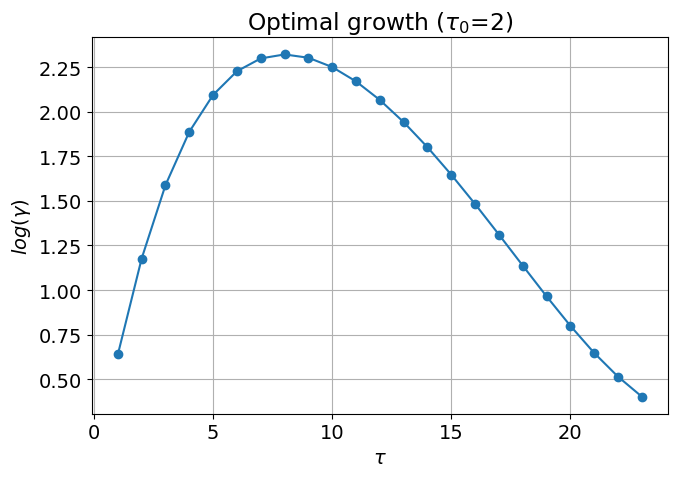

In [10]:
# Plot growth
fig, ax = plt.subplots()
ax.plot(growth['lag'], np.log(growth['growth']), 'o-', label='growth')
_ = ax.set_xlabel(r"$\tau$")
_ = ax.set_ylabel(r"$log(\gamma)$")
_ = ax.set_title(rf"Optimal growth ($\tau_0$={model.tau_0})")
ax.grid('y')

### Optimal initial conditions

In [11]:
# Transform to grid space
z_init = np.array(growth['init_condition'])
x_init = pca_coll.reconstruction(z_init, times=growth['lag'])
# Unnormalize
x_init = xr.merge(
    [ds[var].attrs['normalizer'].inverse_transform(x_init[var]) for var in ds.data_vars]
)
x_init = x_init.rename_dims({"time":"lag"})

/home/jakob/Code/forenso/forenso/utils/preproc.py:540: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[:, ids_notNaN.data] = x_flat


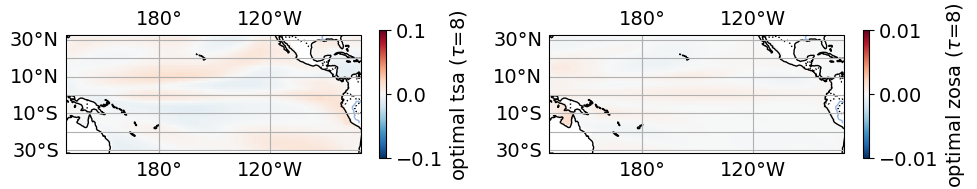

In [12]:
lag = 8
x_init_map = x_init.sel(lag=lag)

plparam = {'tsa': dict(vmin=-.1, vmax=.1, eps=0.25),
           'zosa': dict(vmin=-.01, vmax=.01, eps=0.025)}

fig = plt.figure(figsize=(len(x_init_map.data_vars) * 5, 2))
proj=ctp.crs.PlateCarree(central_longitude=180)

for j, var in enumerate(list(x_init_map.data_vars)):
    ax = fig.add_subplot(1, len(x_init_map.data_vars), j+1, projection=proj)
    gpl.plot_map(x_init_map[var], 
                 ax=ax, central_longitude=180,
                 bar='continuous', **plparam[var],
                 kwargs_cb=dict(label=rf"optimal {var} ($\tau$={lag})"))
plt.tight_layout()
plt.show()



## Choose $\tau_0$

In [ ]:
# Check for Nyquist mode
reload(lim)
tau_arr = np.arange(1, 13, 1)
eigval_range = []
max_eig_Q = []
for i, tau in enumerate(tau_arr):
    print(f"tau0 = {tau}")
    m_lim = lim.LIM(tau=tau)
    m_lim.fit(data_train.data)
    
    w_G,_,_ = lim.matrix_decomposition(m_lim.G)
    eigval_range.append([
        np.min(w_G), np.max(w_G)
    ])
    w_Q, _, _ = lim.matrix_decomposition(m_lim.Q)
    max_eig_Q.append(np.max(np.abs(np.imag(w_Q))))
eigval_range = np.array(eigval_range)
max_eig_Q = np.array(max_eig_Q)

In [ ]:
# Plot 
fig, axs = plt.subplots(2, sharex=True)
axs[0].bar(tau_arr, height=eigval_range[:,1]- eigval_range[:,0], bottom=eigval_range[:,0],
           label=r'[min($\lambda_{G}$), max($\lambda_{G}$)]')
axs[0].axhline(0, color='k')
axs[0].set_xlabel(r'$\tau_0$')
axs[0].set_xticks(tau_arr)
axs[0].set_ylabel(r'$\lambda_{G}$')
axs[0].legend()

axs[1].bar(tau_arr, height=max_eig_Q, label=r"max(Im($\lambda_Q$))")
axs[1].set_xticks(tau_arr)
axs[1].set_xlabel(r"$\tau_0$")
axs[1].set_ylabel(r"Im($\lambda_Q$))")

### Lagged-correlation in time

$C_\tau = <x(t+\tau) x(t)$>

In [ ]:
lag_arr = np.arange(1, 24, 2)
data_grid = pca_coll.X
# Data crosscorrelation 
C_data = []
trC_data = []
for lag in lag_arr:
    x = data_grid.data.T[:, :-lag]
    x_lag = data_grid.data.T[:, lag:]
    C_lag = (x_lag @ x.T) / x.shape[1]
    C_data.append(dict(C=C_lag, lag=lag))
    trC_data.append(np.trace(C_lag)/ C_lag.shape[0])

In [ ]:
# Lagged covariance of EOF
lag_arr_eof = np.arange(1, 24, 1)
trC_eof = []
for lag in lag_arr_eof:
    x = data.data[:, :-lag]
    x_lag = data.data[:, lag:]
    alpha_lag_eof = (x_lag @ x.T)/x.shape[1]
    C_lag_eof = pca_coll.inverse_transform_covariance(alpha_lag_eof)
    trC_eof.append(np.mean([np.trace(c)/c.shape[0] for c in C_lag_eof]))

In [ ]:
# LIM cross correlation
reload(lim)
lag_arr_lim = np.arange(1, 24, 1)
tau_arr = np.arange(1, 8, 1)
fig = plt.figure(figsize=(6, 3*len(tau_arr)))
for i, tau in enumerate(tau_arr):
    m_lim = lim.LIM(tau=tau)
    m_lim.fit(data.data)
    alpha_lim = m_lim.lagged_correlation(lag_arr_lim)
    trC_lim = []
    for alpha in alpha_lim:
        C_lag_lim = pca_coll.inverse_transform_covariance(alpha)
        trC_lim.append(np.mean([np.trace(c)/c.shape[0] for c in C_lag_lim]))

    # Plot
    ax = fig.add_subplot(len(tau_arr),1,i+1)
    ax.plot(lag_arr, np.array(trC_data), 'o-', label=r"Tr($C_\tau$)(data)")
    ax.plot(lag_arr_eof, trC_eof, 'o-', label=rf"Tr($C(\tau)$) (eof)")
    ax.plot(lag_arr_lim, trC_lim, 'o-', label=rf"Tr($C(\tau)$) (LIM $\tau_0$={m_lim.tau_0})")
    ax.set_xlabel(r"$\tau$")
    ax.set_xticks(lag_arr)
    ax.set_ylabel(r"Tr($C(\tau)$)")
    ax.set_yscale('linear')
    ax.legend()

## Choose number of EOFs

TODO: Adapt this part for the PCACollection

In [ ]:
lag_arr = np.array([1, 6, 12, 18, 24])
# Data crosscorrelation 
C_data = []
trC_data = []
for lag in lag_arr:
    x = pca.X.data.T[:, :-lag]
    x_lag = pca.X.data.T[:, lag:]
    C_lag = (x_lag @ x.T) / x.shape[1]
    autocorr_arr = np.diag(C_lag)
    autocorr_map = pca.flattened2map(autocorr_arr)
    C_data.append(dict(C=C_lag, lag=lag, autocorr=autocorr_map))

### Autocorrelation of LIM

In [ ]:
reload(eof)
reload(lim)
num_components = np.arange(2, 27, 6)
num_components = np.array([2,5,10,15,20])
n_time = len(da['time'])
store_eof = []
store_lim = []
for i, n_comp in enumerate(num_components):
    npca = eof.SpatioTemporalPCA(da, n_components=n_comp)
    npca_ts = npca.get_principal_components()

    m_lim = lim.LIM(tau=1)
    m_lim.fit(npca_ts.data)

    for lag in lag_arr:
        # EOFs autocorrelation
        x = npca_ts.data[:, :-lag]
        x_lag = npca_ts.data[:, lag:]
        alpha_lag_eof = (x_lag @ x.T) / x.shape[1]
        C_lag_eof = npca.pca.components_.T @ alpha_lag_eof @ npca.pca.components_
        autocorr_eof_arr = np.diag(C_lag_eof)
        autocorr_eof_map = npca.flattened2map(autocorr_eof_arr)
        store_eof.append(dict(n_comp=n_comp, pca=npca, lag=lag, C=C_lag_eof, autocorr=autocorr_eof_map))

        # lim autocorrelation
        alpha_lag_lim = m_lim.lagged_correlation([lag])[0]
        C_lag_lim = npca.pca.components_.T @ alpha_lag_lim @ npca.pca.components_
        autocorr_lim_arr = np.diag(C_lag_lim)
        autocorr_lim_map = npca.flattened2map(autocorr_lim_arr)
        store_lim.append(dict(n_comp=n_comp, lim=m_lim, lag=lag, C=C_lag_lim, autocorr=autocorr_lim_map))

In [ ]:
fig = plt.figure(figsize=(len(lag_arr)*4, (len(num_components)+1)*2))
proj=ctp.crs.PlateCarree(central_longitude=180)

for c_lag in C_data:
    i = np.where(lag_arr == c_lag['lag'])[0]
    ax = fig.add_subplot(len(num_components)+1, len(lag_arr), int(i+1), projection=proj)
    gpl.plot_map(c_lag['autocorr'], ax=ax, central_longitude=180,
                 label=rf"Data: $\tau$={c_lag['lag']}",
                 vmin=-1, vmax=1,
                 kwargs_cb=dict(orientation='vertical', shrink=0.8))

for storer in store_lim:
    i = np.where(num_components == storer['n_comp'])[0]
    j = np.where(lag_arr == storer['lag'])[0]
    idx = int(len(lag_arr)*(i+1) + j + 1)
    ax = fig.add_subplot(len(num_components)+1, len(lag_arr), idx, projection=proj)
    gpl.plot_map(storer['autocorr'], ax=ax, central_longitude=180,
                 label=(r"LIM: $n_{eof}=$"+ f"{storer['n_comp']}" + rf", $\tau$={storer['lag']}"),
                 vmin=-1, vmax=1,
                 kwargs_cb=dict(orientation='vertical', shrink=0.8))
